# Project: Soccer Database Analysis - What makes a Team successful?

## Table of Contents

- [Introduction](#introduction)
    - [Packages used](#packages-used)
    - [Pandas options](#pandas-options)
    - [List of Database Tables](#list-of-database-tables)
    - [Description of Tables and Fields](#description-of-tables-and-fields)
    - [Data used in this project](#data-used-in-this-project)
    - [Questions](#questions)
- [Data Wrangling](#data-wrangling)
    - [Number of Rows per Table](#number-of-rows-per-table)
    - [Load Data into Dataframes](#load-data-into-dataframes)
    - [General Information](#general-information)
        - [Datatypes](#datatypes)
    - [Are there duplicates in team?](#are-there-duplicates-in-team)
        - [Remove duplicates in **teams**](#remove-duplicates-in-teams)
    - [Does Home Team equals Away Team?](#does-home-team-equals-away-team)
    - [Did one team play more than once on a matchday?](#did-one-team-play-more-than-once-on-a-matchday)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [What teams performed best over all leagues and seasons?](#what-teams-performed-best-over-all-leagues-and-seasons)
    - [Did the teams improve over the time period?](#did-the-teams-improve-over-the-time-period)
    - [What contributes to this performance?](#what-contributes-to-this-performance)
        - [Number of goals shooten](#number-of-goals-shooten)
        - [Relation between Goals Shooten and Percentage of won matches](#relation-between-goals-shooten-and-percentage-of-won-matches)
        - [Goal Balance](#goal-balance)
        - [Goal Breakdown](#goal-breakdown)
- [Conclusions](#conclusions)
- [Outlook](#outlook)
- [Appendix A: Entity-Relationship Model of Soccer Database](#appendix-a-entity-relationship-model-of-soccer-database)
- [Appendix B: Table Fields](#appendix-b-table-fields)
    - [Country](#country)
    - [League](#league)
    - [Match](#match)
    - [Player](#player)
    - [Player_Attributes](#player_attributes)
    - [Team](#team)
    - [Team_Attributes](#team_attributes)
- [Appendix C: References](#appendix-c-references)

<a id='introduction'></a>
## Introduction

The Data Analysis process starts by asking questions.
Sometimes it starts by first asking questions and then collecting the data needed to get the answers.
In this project the process starts the other way around: There is data and the analyst figures out questions to be answered using this data.

The data in this project is taken from a soccer SQLite database hosted on [Kaggle](https://www.kaggle.com/hugomathien/soccer/home).
According to its description it contains:

- 25,000 matches
- 10,000 players
- 11 European Countries with their lead championship
- Seasons 2008 to 2016
- Players and Teams' attributes sourced from EA Sports' FIFA video game series, including the weekly updates
- Team line up with squad formation (X, Y coordinates)
- Betting odds from up to 10 providers
- Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches

To extract this data standard SQL is used. 
To analyze the data Python is used.

The main table in the database contains data for soccer matches. 
Data for players, teams, and leagues are referenced from other tables.
The ER model is shown in [Appendix A: Entity-Relationship Model of Soccer Database](#appendix-a-entity-relationship-model-of-soccer-database).

<a id='packages-used'></a>
### Packages used

In [1]:
import sqlite3 # for sqlite
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # plotting
import matplotlib.ticker as mtick # plotting formatter
import seaborn as sns # plot formatting
import math # rounding
% matplotlib inline

<a id='pandas-options'></a>
### Pandas options

As this notebook will be printed later the maximum length of the output is set unlimited.

In [2]:
pd.set_option('max_rows', None)

<a id='list-of-database-tables'></a>
### List of Database Tables

The first step is to explore what data is store in this database.
To display all tables a SQL query is used:

In [3]:
# create connection to the database
db_connection = sqlite3.connect('soccerDatabase.sqlite')

In [4]:
# read and display the tables in the database
pd.read_sql_query("""SELECT tbl_name
                       FROM sqlite_master
                      WHERE type = 'table';""", db_connection)

,tbl_name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


<a id='description-of-tables-and-fields'></a>
### Description of Tables and Fields

To find out the meaning of the tables and fields I needed to visit these sources:

* [FIFA Encyclopedia: List of Player Attributes](http://www.fifplay.com/encyclopedia/player-attributes/)
* [FIFA 18: Short explanation of Player Attributes](http://www.fifplay.com/fifa-18-player-attributes/)
* [FIFA 18 Tactics: Short explanation of Team Attributes](http://www.fifplay.com/fifa-18-tactics/)
* [Examples of football-data via a REST API](http://api.football-data.org)
* [Field Names for Betting Odds](http://www.football-data.co.uk/notes.txt)

In addition I read some of the Kernels available at Kaggle: 

* [Data Analysis using SQL](https://www.kaggle.com/dimarudov/data-analysis-using-sql)
* [The Most Predictable League](https://www.kaggle.com/yonilev/the-most-predictable-league)
* [Can you be a good football player?](https://www.kaggle.com/doctorclo/can-you-be-a-good-football-player)
* [Squad Visualization (XY Coordinate)](https://www.kaggle.com/hugomathien/squad-visualization-xy-coordinate)
* [Predicting EPL Scores for Fun](https://www.kaggle.com/petehodge/predicting-epl-scores-for-fun)
* [Which players influence betting ?](https://www.kaggle.com/yoyocm/which-players-influence-betting)


The names of the tables already describe what data is stored in them:

* **Country**

    Stores a list of Countries.


* **League**

    Holds a list of the names of Soccer Leagues and References the **Country** table to link the name of a league to its' country.


* **Player**

    Basic information for every Player picked for a Match.


* **Player_Attributes**

    Detailed statistics for every Player imported from FIFA video game series. This includes various information about his strengths, weaks, position etc.


* **Team**

    Basic information for every Team played a Match.


* **Team_Attributes**

    Summary of overall statistics of a team over a season. This is imported from FIFA video game series too.


* **Match**

    Contains details and events for every match played. It references **Country**, **League**, **Player** and **Team**. In addition Betting Odds from different betting providers are included.

The _PRAGMA_ **table_info()** was used to display the field information.
To see a list of all fields and their meanings refer to [Appendix B: Table Fields](#appendix-b-table-fields).

<a id='data-used-in-this-project'></a>
### Data used in this project

During the process of getting familiar with the dataset I discovered that the Team attributes are not recorded for every year covered in the dataset.
Of 8 years only 6 are available:

In [5]:
pd.read_sql_query("""SELECT DISTINCT season 
                       FROM Match
                      ORDER BY season;""", db_connection)

,season
0,2008/2009
1,2009/2010
2,2010/2011
3,2011/2012
4,2012/2013
5,2013/2014
6,2014/2015
7,2015/2016


In contrast team attributes stored only for 6 years:

In [6]:
pd.read_sql_query("""SELECT DISTINCT date 
                       FROM Team_Attributes 
                      ORDER BY 1;""", db_connection)

,date
0,2010-02-22 00:00:00
1,2011-02-22 00:00:00
2,2012-02-22 00:00:00
3,2013-09-20 00:00:00
4,2014-09-19 00:00:00
5,2015-09-10 00:00:00


I therefore decided to avoid using Team attributes.

As the data stored for every match is very detailed this project uses this data.

<a id='questions'></a>
### Questions

Every competition is done to find the **best**.
In soccer the best team is the team winning the most matches.
Hence to find out who is the best of all teams I calculate the percentage of winning matches over all matches played.

The questions I will answer:

1. What teams performed best over all leagues and seasons?
2. Did the teams improve over the time period?
3. What contributes to this performance?

To answer these questions I explore

- Percentage of matches won over all time.
- Percentage of matches won for every season.
- The total number of goals made.
- Goal Difference - that means Goals shooten minus Goals conceded.
- Breakdown of goals shooten and goals conceded for every team.

<a id='data-wrangling'></a>
## Data Wrangling

<a id='number-of-rows-per-table'></a>
### Number of Rows per Table

First I will see how many rows are stored per table. 
I will not need all of them but having this information might be handy later on:

In [7]:
pd.read_sql_query("""SELECT "Country" table_name, count(*) "Rows" FROM Country 
                      UNION
                     SELECT "League" table_name, count(*) "Rows" FROM League 
                      UNION
                     SELECT "Match" table_name, count(*) "Rows" FROM Match 
                      UNION
                     SELECT "Player" table_name, count(*) "Rows" FROM Player 
                      UNION
                     SELECT "Player_Attributes" table_name, count(*) "Rows" FROM Player_Attributes 
                      UNION
                     SELECT "Team" table_name, count(*) "Rows" FROM Team 
                      UNION
                     SELECT "Team_Attributes" table_name, count(*) "Rows" FROM Team_Attributes;""", db_connection)

,table_name,Rows
0,Country,11
1,League,11
2,Match,25979
3,Player,11060
4,Player_Attributes,183978
5,Team,299
6,Team_Attributes,1458


<a id='load-data-into-dataframes'></a>
### Load Data into Dataframes

As I only use data from tables **Match** and **Team** I load a subset of these tables.
Using SQL gives me the possibility to drop a lot of columns in the first place. 
So I don't need to do that later. 
This gives me a lot smaller dataframe as well.

In addition I can calculate derived columns if needed and can rename columns directly during the query.

The data I will use:

- From **Match** I need
    - **season** to break down the progress the teams made by season.
    - **stage** for data wrangling
    - **home_team_api_id** and **away_team_api_id** to make groupby easier and to store the ID in a derived column.
    - **home_team_goal** and **away_team_goal** to break down the goals to goals made and conceded
    - In addition I create two derived columns: 
        - **goals** is calculated as sum of **home_team_goal** and **away_team_goal**
        - **winner_team** stores the ID of the team that won the match or **0**
- From **Team** I'll load a mapping dataframe to have the team name indexed by it's ID.

I store **0** in **winner_team** to show a draw. 
Storing **NULL** leads to Pandas converting this column to float. 
As the source columns are integers I want to have this column as integer as well.

In [8]:
# define query string to query all matches joined with team data
matches_query = """SELECT Match.id match_id
                        , Match.season
                        , Match.stage
                        , Match.home_team_api_id home_id
                        , Match.away_team_api_id away_id
                        , Match.home_team_goal home_team_goals
                        , Match.away_team_goal away_team_goals
                        , Match.home_team_goal + Match.away_team_goal "goals"
                        , CASE
                              WHEN Match.home_team_goal > Match.away_team_goal
                                  THEN Match.home_team_api_id
                              WHEN Match.home_team_goal < Match.away_team_goal
                                  THEN Match.away_team_api_id
                              ELSE
                                  0
                          END winner_team
                     FROM Match;"""

# define team query
teams_query = """SELECT Team.team_api_id team_id
                       , Team.team_long_name team
                    FROM Team;"""

In [9]:
matches = pd.read_sql_query(matches_query, db_connection, index_col='match_id')
teams = pd.read_sql_query(teams_query, db_connection, index_col='team_id')

<a id='general-information'></a>
### General Information

Do the frames look like we need it:

In [10]:
matches.head()

,season,stage,home_id,away_id,home_team_goals,away_team_goals,goals,winner_team
match_id,,,,,,,,
1,2008/2009,1,9987,9993,1,1,2,0
2,2008/2009,1,10000,9994,0,0,0,0
3,2008/2009,1,9984,8635,0,3,3,8635
4,2008/2009,1,9991,9998,5,0,5,9991
5,2008/2009,1,7947,9985,1,3,4,9985


In [11]:
teams.head()

,team
team_id,
9987,KRC Genk
9993,Beerschot AC
10000,SV Zulte-Waregem
9994,Sporting Lokeren
9984,KSV Cercle Brugge


The Dataframes hold only the information I need for analysis.
All columns are already named in a consistent schema. 
The columns **match_id** and **team_id** - which are the *primary key* in the tables - are used as index.

I thought about doing aggregations later on in SQL as well but decided against that.
In this small project it might be no difference doing SQL queries for aggregations and groupings.
But in larger projects I assume the overhead of database roundtrips much higher.
So I tend to load the data needed as long as the memory needed is not that large.

<a id='datatypes'></a>
#### Datatypes

Now I can check the data types pandas used for *matches* and *teams*.

In [12]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 1 to 25979
Data columns (total 8 columns):
season             25979 non-null object
stage              25979 non-null int64
home_id            25979 non-null int64
away_id            25979 non-null int64
home_team_goals    25979 non-null int64
away_team_goals    25979 non-null int64
goals              25979 non-null int64
winner_team        25979 non-null int64
dtypes: int64(7), object(1)
memory usage: 1.8+ MB


Points to single out:

- There are 25979 entries - as expected the same number of rows exist in the *Match* table.
- There are no Null-Values in the Dataframe. Every column has 25979 non-null entries.
- **season** is loaded as string data correctly.
- All other columns are converted to int64 as they are INTEGERS in SQLite.

What about **teams**?

In [13]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 9987 to 7896
Data columns (total 1 columns):
team    299 non-null object
dtypes: object(1)
memory usage: 4.7+ KB


As I only loaded one column everything is as expected here.
The team name is stored as string.

<a id='are-there-duplicates-in-team'></a>
### Are there duplicates in team?

First I'll check for duplicates in **team**.

In [14]:
teams.duplicated().sum()

3

There are 3 duplicates.

<a id='remove-duplicates-in-teams'></a>
#### Remove duplicates in **teams**

First I list all duplicates.

In [15]:
teams.loc[teams['team'].isin(teams.loc[teams.duplicated()]['team'].values)]

,team
team_id,
9996,Royal Excel Mouscron
274581,Royal Excel Mouscron
8031,Polonia Bytom
8020,Polonia Bytom
8244,Widzew Łódź
8024,Widzew Łódź


That means that I do have to 

1. drop three teams
2. replace all team ids in **matches** with the team_id that remains in **teams**.

I will drop the higher IDs.
As there are only 3 duplicates I will fill in the IDs manually.

In [16]:
ids=[274581, 8031, 8244]
teams.drop(ids, inplace=True)
teams.duplicated().sum()

0

In [17]:
(len(matches.loc[matches.home_id.isin(ids)]),
 len(matches.loc[matches.away_id.isin(ids)]),
 len(matches.loc[matches.winner_team.isin(ids)]))

(105, 105, 54)

There are 105 values to replace in home_id and away_id of *matches*. The winner team must be replaced 54 times.

In [18]:
matches.replace({'home_id': {274581: 9996, 8031: 8020, 8244: 8024},
                 'away_id': {274581: 9996, 8031: 8020, 8244: 8024},
                 'winner_team': {274581: 9996, 8031: 8020, 8244: 8024}}, inplace=True)
(len(matches.loc[matches.home_id.isin(ids)]),
 len(matches.loc[matches.away_id.isin(ids)]),
 len(matches.loc[matches.winner_team.isin(ids)]))

(0, 0, 0)

Now this frame is clean.
As **matches** does have multiple columns the check on duplicates is done only on selected columns as follows.

<a id='does-home-team-equals-away-team'></a>
### Does Home Team equals Away Team?

What should not be possible is that one team is recorded twice as **home** and **away** team.
So I check that next:

In [19]:
len(matches.query('home_id == away_id'))

6

There are 6 invalid matches.
List these 6 rows.

In [20]:
matches.query('home_id == away_id')

,season,stage,home_id,away_id,home_team_goals,away_team_goals,goals,winner_team
match_id,,,,,,,,
15850,2008/2009,24,8020,8020,2,0,2,8020
15945,2008/2009,7,8020,8020,2,0,2,8020
16231,2010/2011,12,8020,8020,1,1,2,0
16359,2010/2011,27,8020,8020,1,2,3,8020
16455,2011/2012,10,8024,8024,0,1,1,8024
16584,2011/2012,25,8024,8024,1,1,2,0


These 6 matches are there due to the duplicated entries in **teams**.
As there are only these 6 invalid entries I just delete them from the matches frame.

In [21]:
matches.drop(matches.query('home_id == away_id').index, inplace=True)
len(matches.query('home_id == away_id'))

0

This data is correct now. 

<a id='did-one-team-play-more-than-once-on-a-matchday'></a>
### Did one team play more than once on a matchday?

Now I check whether one team plays more then once on a given matchday.
To check that I first create two copies of the Dataframe holding the match data.
These frames will be then cleared to hold only the data of home matches or away matches.

In [22]:
home_matches = matches.copy()
away_matches = matches.copy()

I clean these dataframes further by

- derive a new column 'won' that holds a bool whether the team of this frame has won the match
- drop unneeded columns
- rename remaining columns so that both use the same names because I will concat them

In [23]:
home_matches['won'] = np.where(home_matches.home_id == home_matches.winner_team, True, False)
home_matches.drop(columns=['away_id','goals', 'winner_team'], inplace=True)
home_matches.rename(index=str, columns={'home_id':'team_id'
                                      , 'home_team_goals':'goals_shooten'
                                      , 'away_team_goals':'goals_conceded'}, inplace=True)
home_matches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25973 entries, 1 to 25979
Data columns (total 6 columns):
season            25973 non-null object
stage             25973 non-null int64
team_id           25973 non-null int64
goals_shooten     25973 non-null int64
goals_conceded    25973 non-null int64
won               25973 non-null bool
dtypes: bool(1), int64(4), object(1)
memory usage: 1.2+ MB


One point I might have to deal with later on: The int64 Index of matches was converted to an 'Index'. 
That means the index is converted to strings. 

The other transformations are correct. 

In [24]:
home_matches.head()

,season,stage,team_id,goals_shooten,goals_conceded,won
match_id,,,,,,
1,2008/2009,1,9987,1,1,False
2,2008/2009,1,10000,0,0,False
3,2008/2009,1,9984,0,3,False
4,2008/2009,1,9991,5,0,True
5,2008/2009,1,7947,1,3,False


I can check this now for duplicates on **stage** and **team_id**.

In [25]:
home_matches[['season','stage','team_id']].duplicated().sum()

13

List these rows:

In [26]:
home_matches.loc[home_matches[['season','stage','team_id']].duplicated()]

,season,stage,team_id,goals_shooten,goals_conceded,won
match_id,,,,,,
15825,2008/2009,20,8020,1,1,False
15921,2008/2009,4,8020,4,1,True
15929,2008/2009,5,8020,1,0,True
16217,2010/2011,10,8020,0,0,False
16318,2010/2011,22,8020,0,2,False
16351,2010/2011,26,8020,1,2,False
16416,2010/2011,6,8020,1,0,True
16432,2010/2011,8,8020,2,2,False
16449,2011/2012,1,8024,1,1,False


These are due to the duplicated entries in **teams** again.
So I will drop these as well.

In [27]:
home_matches.drop(home_matches.loc[home_matches[['season','stage','team_id']].duplicated()].index, inplace=True)
home_matches[['season','stage','team_id']].duplicated().sum()

0

The same is done for the frame holding the away team of matches.

In [28]:
away_matches['won'] = np.where(away_matches.away_id == away_matches.winner_team, True, False)
away_matches.drop(columns=['home_id','goals', 'winner_team'], inplace=True)
away_matches.rename(index=str, columns={'away_id':'team_id'
                                      , 'away_team_goals':'goals_shooten'
                                      , 'home_team_goals':'goals_conceded'}, inplace=True)
away_matches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25973 entries, 1 to 25979
Data columns (total 6 columns):
season            25973 non-null object
stage             25973 non-null int64
team_id           25973 non-null int64
goals_conceded    25973 non-null int64
goals_shooten     25973 non-null int64
won               25973 non-null bool
dtypes: bool(1), int64(4), object(1)
memory usage: 1.2+ MB


In [29]:
away_matches.head()

,season,stage,team_id,goals_conceded,goals_shooten,won
match_id,,,,,,
1,2008/2009,1,9993,1,1,False
2,2008/2009,1,9994,0,0,False
3,2008/2009,1,8635,0,3,True
4,2008/2009,1,9998,5,0,False
5,2008/2009,1,9985,1,3,True


I assume that this frame holds again some duplicates.

In [30]:
away_matches[['season','stage','team_id']].duplicated().sum()

13

That matches the number of duplicates of the home_matches as well.
That makes sense.

In [31]:
away_matches.loc[away_matches[['season','stage','team_id']].duplicated()]

,season,stage,team_id,goals_conceded,goals_shooten,won
match_id,,,,,,
15833,2008/2009,21,8020,0,1,True
15835,2008/2009,22,8020,1,0,False
15903,2008/2009,3,8020,3,0,False
16223,2010/2011,11,8020,0,1,True
16312,2010/2011,21,8020,0,2,True
16328,2010/2011,23,8020,3,1,False
16345,2010/2011,25,8020,0,0,False
16422,2010/2011,7,8020,2,2,False
16504,2011/2012,16,8024,1,0,False


In [32]:
away_matches.drop(away_matches.loc[away_matches[['season','stage','team_id']].duplicated()].index, inplace=True)
away_matches[['season','stage','team_id']].duplicated().sum()

0

Now I concat these two and check for duplicates again for all matches. 
During the concat I move *match_id* back into the data to avoid duplicated index entries.
To get that I call **reset_index()** on both Dataframes. 
I set **sort=False** to prevent sorting the columns as this is not needed here.

In [33]:
matches_flat = pd.concat([home_matches.reset_index(), away_matches.reset_index()], ignore_index=True, sort=False)
matches_flat.sort_values(by='match_id').head()

,match_id,season,stage,team_id,goals_shooten,goals_conceded,won
0,1,2008/2009,1,9987,1,1,False
25960,1,2008/2009,1,9993,1,1,False
25969,10,2008/2009,10,8571,1,4,False
9,10,2008/2009,10,8342,4,1,True
26059,100,2008/2009,2,10000,0,2,False


In [34]:
matches_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51920 entries, 0 to 51919
Data columns (total 7 columns):
match_id          51920 non-null object
season            51920 non-null object
stage             51920 non-null int64
team_id           51920 non-null int64
goals_shooten     51920 non-null int64
goals_conceded    51920 non-null int64
won               51920 non-null bool
dtypes: bool(1), int64(4), object(2)
memory usage: 2.4+ MB


In [35]:
matches_flat[['season','stage','team_id']].duplicated().sum()

58

These are the remaining matches that are left over from the cleanup of **teams** above.

In [36]:
matches_flat.loc[matches_flat[['season','stage','team_id']].duplicated()]

,match_id,season,stage,team_id,goals_shooten,goals_conceded,won
41681,15722,2008/2009,1,8020,0,1,False
41695,15736,2008/2009,10,8020,3,1,True
41701,15742,2008/2009,11,8020,0,1,False
41709,15750,2008/2009,12,8020,0,0,False
41717,15758,2008/2009,13,8020,0,1,False
41726,15767,2008/2009,14,8020,2,2,False
41730,15771,2008/2009,15,8020,0,2,False
41744,15785,2008/2009,16,8020,0,1,False
41748,15789,2008/2009,17,8020,0,3,False
41758,15799,2008/2009,18,8020,1,0,True


I'll drop them as well.

In [37]:
matches_flat.drop(matches_flat.loc[matches_flat[['season','stage','team_id']].duplicated()].index, inplace=True)
matches_flat[['season','stage','team_id']].duplicated().sum()

0

In [38]:
matches_flat.duplicated().sum()

0

There are no NULL values and no duplicates in matches now.

<a id='exploratory-data-analysis'></a>
## Exploratory Data Analysis

<a id='what-teams-performed-best-over-all-leagues-and-seasons'></a>
### What teams performed best over all leagues and seasons?

To calculate this I use a simple algorithm: I calculate the percentage of matches won for every team. 
The best teams are the teams with the highest percentage of won matches.

**But**: It is expected that not all teams played in all seasons due to relegation. 
So I only calculate the percentage won for those teams that played in all recorded seasons.
To do that I first create a Pandas Series by grouping **matches_flat** by **team_id** and count the unique values of **season** per group.
After that **where** is used to replace all values lower than the maximum number of seasons with NaN, these rows are dropped and the resulting index is stored in **full_teams_index**.

In [39]:
num_seasons_per_team = matches_flat.groupby('team_id')['season'].nunique()
full_teams_index = num_seasons_per_team.where(num_seasons_per_team == num_seasons_per_team.max()).dropna().index
num_seasons_per_team.head()

team_id
1601    8
1773    3
1957    8
2033    5
2182    8
Name: season, dtype: int64

In [40]:
full_teams_index

Int64Index([ 1601,  1957,  2182,  6403,  7841,  7844,  8020,  8025,  8030,
             8178,  8226,  8277,  8302,  8305,  8315,  8455,  8456,  8472,
             8485,  8533,  8535,  8543,  8558,  8564,  8586,  8592,  8593,
             8597,  8600,  8611,  8633,  8634,  8636,  8639,  8640,  8650,
             8668,  8673,  8674,  8686,  8689,  8697,  8721,  9748,  9768,
             9772,  9773,  9788,  9789,  9790,  9791,  9823,  9825,  9827,
             9831,  9847,  9851,  9853,  9864,  9875,  9885,  9904,  9906,
             9908,  9925,  9927,  9931,  9938,  9941,  9956,  9991, 10179,
            10189, 10192, 10194, 10199, 10212, 10214, 10215, 10217, 10228,
            10229, 10233, 10235, 10238, 10243, 10252, 10260, 10264, 10265,
            10267, 10269],
           dtype='int64', name='team_id')

In [41]:
matches_flat['team_id'].nunique(), full_teams_index.size

(296, 92)

There are only 92 out of 296 teams in the database having played all 8 seasons.
How is the performance of these teams? 

First: Create a new dataframe holding only the matches from **matches_flat** where one of the teams in **full_teams_index** played.

In [42]:
full_teams_matches = matches_flat.loc[matches_flat['team_id'].isin(full_teams_index)]

Display some information about this dataframe:

In [43]:
full_teams_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25917 entries, 3 to 51919
Data columns (total 7 columns):
match_id          25917 non-null object
season            25917 non-null object
stage             25917 non-null int64
team_id           25917 non-null int64
goals_shooten     25917 non-null int64
goals_conceded    25917 non-null int64
won               25917 non-null bool
dtypes: bool(1), int64(4), object(2)
memory usage: 1.4+ MB


In [44]:
full_teams_matches.head()

,match_id,season,stage,team_id,goals_shooten,goals_conceded,won
3,4,2008/2009,1,9991,5,0,True
22,23,2008/2009,11,9991,1,1,False
41,42,2008/2009,13,9991,2,3,False
48,49,2008/2009,14,9991,4,0,True
66,67,2008/2009,16,9991,1,1,False


In [45]:
full_teams_matches['match_id'].nunique()

19340

From the starting 25979 matches I only analyze 19340. 
The other matches were hold only by teams that have not played all 8 seasons.

Second: Create a final dataframe holding the number of all games and the number of games won per team.

In [46]:
full_teams_pct_won = pd.concat([full_teams_matches.groupby('team_id').size()
                              , full_teams_matches.groupby('team_id').won.sum().astype('int64')]
                              , axis=1)
full_teams_pct_won.head()

,0,won
team_id,,
1601,240,92
1957,240,87
2182,240,124
6403,248,80
7841,248,75


Now I do have a dataframe that needs to get enhanced further: 

- Rename the first column to a more descriptive name.
- Add a derived column holding the percentage won.

In [47]:
full_teams_pct_won.rename(index=str, columns={0:'matches'}, inplace=True)
full_teams_pct_won[['pct_won']] = 100 * full_teams_pct_won[['won']].div(full_teams_pct_won.matches, axis=0)
full_teams_pct_won.head()

,matches,won,pct_won
team_id,,,
1601,240,92,38.333333
1957,240,87,36.250000
2182,240,124,51.666667
6403,248,80,32.258065
7841,248,75,30.241935


The last step is to add the name of the Team as the plots should have the name not the id.
As the index is converted to strings by the above cell it needs to be converted to int64 because otherwise merging with **teams** will not work.

In [48]:
full_teams_pct_won.index = full_teams_pct_won.index.astype('int64')
full_teams_pct_won = pd.merge(full_teams_pct_won, teams, left_index=True, right_index=True, how='left')
full_teams_pct_won.head()

,matches,won,pct_won,team
team_id,,,,
1601,240,92,38.333333,Ruch Chorzów
1957,240,87,36.250000,Jagiellonia Białystok
2182,240,124,51.666667,Lech Poznań
6403,248,80,32.258065,FC Paços de Ferreira
7841,248,75,30.241935,Rio Ave FC


In [49]:
full_teams_pct_won.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 1601 to 10269
Data columns (total 4 columns):
matches    92 non-null int64
won        92 non-null int64
pct_won    92 non-null float64
team       92 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 6.1+ KB


Now I can find the top 10 of this Frame:

In [50]:
full_teams_pct_won.nlargest(10, 'pct_won')

,matches,won,pct_won,team
team_id,,,,
8634,304,234,76.973684,FC Barcelona
8633,304,228,75.000000,Real Madrid CF
9772,248,185,74.596774,SL Benfica
9773,248,183,73.790323,FC Porto
9925,304,218,71.710526,Celtic
9823,272,193,70.955882,FC Bayern Munich
8593,272,181,66.544118,Ajax
8640,272,178,65.441176,PSV
10260,304,192,63.157895,Manchester United


In contrast the average percentage of matches won over all these teams is

In [51]:
pct_mean = full_teams_pct_won['pct_won'].mean()
pct_mean

44.59951296135123

This **Top 10** as Plot:

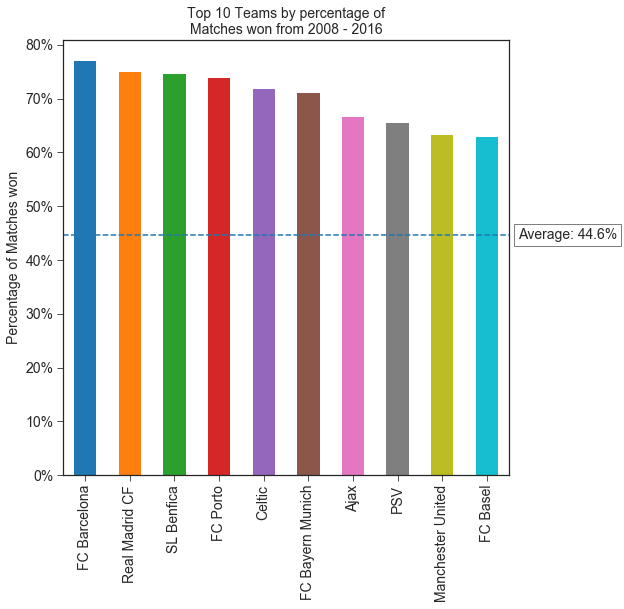

In [52]:
# set style 
plt.style.use('seaborn-ticks')

# create plot
ax = full_teams_pct_won.nlargest(10, 'pct_won').plot.bar(x='team', y='pct_won', figsize=(8,8), legend=False,
                                       title='Top 10 Teams by percentage of\nMatches won from 2008 - 2016')
# set labels
ax.set_ylabel('Percentage of Matches won')
ax.set_xlabel('') # only show xticklabels - remove xlabel

# add Average on hline
ax.axhline(pct_mean, linestyle='--')

# format ylabels as Percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# add textbox on the right to display the average
ax.text(1.02, pct_mean, 'Average: {}%'.format(math.ceil(pct_mean*100)/100), va='center', ha="left", 
        bbox=dict(facecolor="w",alpha=0.5), transform=ax.get_yaxis_transform(), fontsize=14)

# set fontsize
for item in ([ax.title, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14);

<a id='did-the-teams-improve-over-the-time-period'></a>
### Did the teams improve over the time period?

Now I'd like to see whether these teams improved over time.
For that I first store the team_ids of these 10 teams in a variable to use that as index.

In [53]:
top_10_teams = full_teams_pct_won.nlargest(10, 'pct_won').index
top_10_teams

Int64Index([8634, 8633, 9772, 9773, 9925, 9823, 8593, 8640, 10260, 9931], dtype='int64', name='team_id')

I can reuse **full_teams_matches** to create a new dataframe holding only the match data of these teams.

In [54]:
top10_teams_matches = full_teams_matches.loc[full_teams_matches['team_id'].isin(top_10_teams)]
top10_teams_matches.head()

,match_id,season,stage,team_id,goals_shooten,goals_conceded,won
1728,1729,2008/2009,1,10260,1,1,False
1738,1739,2008/2009,10,10260,2,0,True
1748,1749,2008/2009,11,10260,4,3,True
1768,1769,2008/2009,13,10260,5,0,True
1798,1799,2008/2009,16,10260,1,0,True


Now the team name is missing and will be merged in again.

In [55]:
top10_teams_matches = pd.merge(top10_teams_matches, teams, how='left', left_on='team_id', right_index=True)
top10_teams_matches.head()

,match_id,season,stage,team_id,goals_shooten,goals_conceded,won,team
1728,1729,2008/2009,1,10260,1,1,False,Manchester United
1738,1739,2008/2009,10,10260,2,0,True,Manchester United
1748,1749,2008/2009,11,10260,4,3,True,Manchester United
1768,1769,2008/2009,13,10260,5,0,True,Manchester United
1798,1799,2008/2009,16,10260,1,0,True,Manchester United


I'll plot the trend in one plot. 
For that I group this frame by two levels:

1. team
2. season

As above I aggregate columns:

- **won** is the sum of all _True_ values
- **match_id** is just counted and is the number of matches per team and season

The resulting Dataframe is using a MultiIndex.
To plot the data I unstack that by level **0**.

In [56]:
aggregations = {'won':'sum', 'match_id':'count'}
top10_won_per_season = top10_teams_matches.groupby(['team','season']).agg(aggregations).unstack(level=0)
top10_won_per_season.head()

won                                                         \
team       Ajax Celtic FC Barcelona FC Basel FC Bayern Munich FC Porto   
season                                                                   
2008/2009  21.0   24.0         27.0     22.0             20.0     21.0   
2009/2010  27.0   25.0         31.0     25.0             20.0     21.0   
2010/2011  22.0   29.0         30.0     21.0             19.0     27.0   
2011/2012  23.0   30.0         28.0     22.0             23.0     23.0   
2012/2013  22.0   24.0         32.0     21.0             29.0     24.0   

                                                            match_id         \
team      Manchester United   PSV Real Madrid CF SL Benfica     Ajax Celtic   
season                                                                        
2008/2009              28.0  19.0           25.0       17.0       34     38   
2009/2010              27.0  23.0           31.0       24.0       34     38   
2010/2011              23.0  20.0           29.0       20.0       34     38   
2011/2012              28.0  21.0           32.0       21.0       34     38   
2012/2013              28.0  22.0           26.0       24.0       34     38   

                                                                             \
team      FC Barcelona FC Basel FC Bayern Munich FC Porto Manchester United   
season                                                                        
2008/2009           38       36               34       30                38   
2009/2010           38       36               34       30                38   
2010/2011           38       36               34       30                38   
2011/2012           38       34               34       30                38   
2012/2013           38       36               34       30                38   

                                         
team      PSV Real Madrid CF SL Benfica  
season                                   
2008/2009  34             38         30  
2009/2010  34             38         30  
2010/2011  34             38         30  
2011/2012  34             38         30  
2012/2013  34             38         30

Now this Dataframe is using a MultiIndex **won** and **match_id**.
To plot that I calculate the percentage won by dividing these two columns.
The dataframe to plot looks like this:

In [57]:
top10_won_pct_per_season = 100 * top10_won_per_season.won / top10_won_per_season.match_id
top10_won_pct_per_season

team,Ajax,Celtic,FC Barcelona,FC Basel,FC Bayern Munich,FC Porto,Manchester United,PSV,Real Madrid CF,SL Benfica
season,,,,,,,,,,
2008/2009,61.764706,63.157895,71.052632,61.111111,58.823529,70.000000,73.684211,55.882353,65.789474,56.666667
2009/2010,79.411765,65.789474,81.578947,69.444444,58.823529,70.000000,71.052632,67.647059,81.578947,80.000000
2010/2011,64.705882,76.315789,78.947368,58.333333,55.882353,90.000000,60.526316,58.823529,76.315789,66.666667
2011/2012,67.647059,78.947368,73.684211,64.705882,67.647059,76.666667,73.684211,61.764706,84.210526,70.000000
2012/2013,64.705882,63.157895,84.210526,58.333333,85.294118,80.000000,73.684211,64.705882,68.421053,80.000000
2013/2014,58.823529,81.578947,71.052632,52.777778,85.294118,63.333333,50.000000,52.941176,71.052632,76.666667
2014/2015,61.764706,76.315789,78.947368,66.666667,73.529412,73.529412,52.631579,85.294118,78.947368,79.411765
2015/2016,73.529412,68.421053,76.315789,72.222222,82.352941,67.647059,50.000000,76.470588,73.684211,85.294118


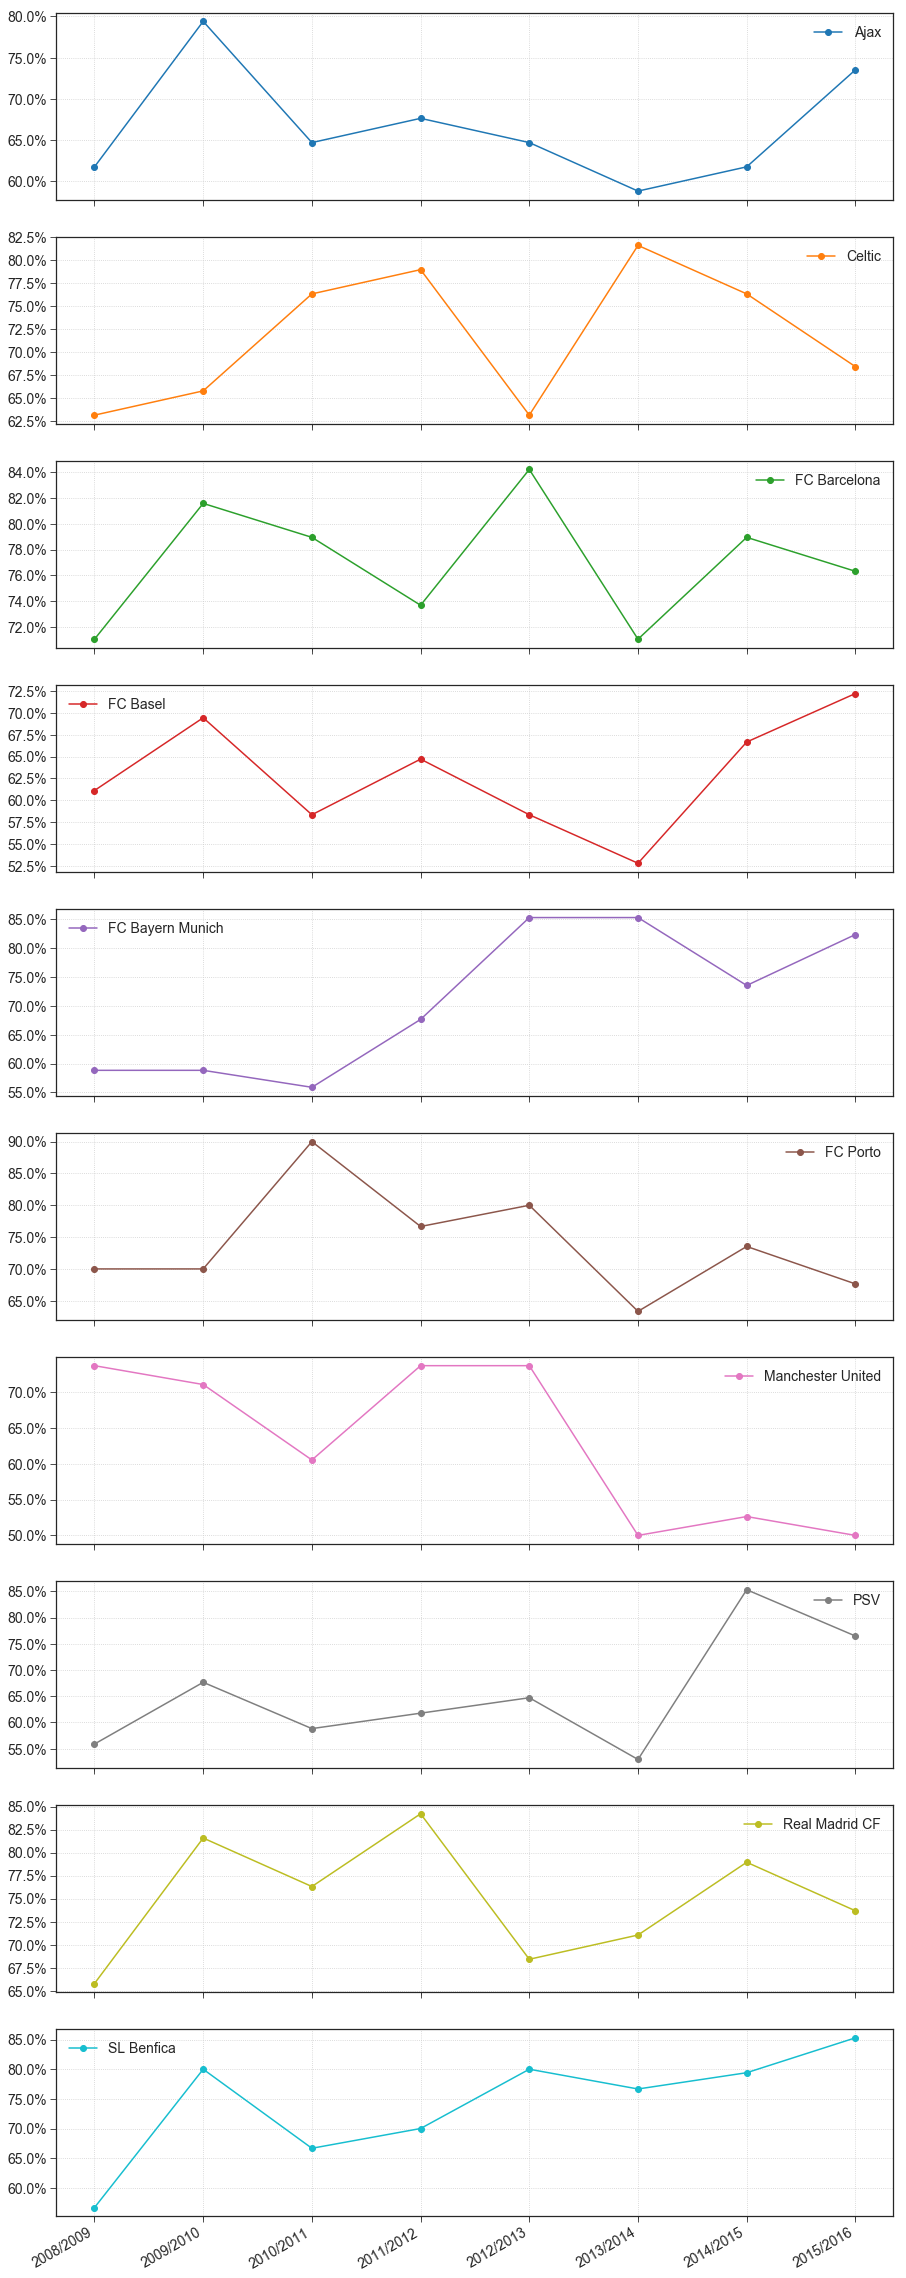

In [58]:
plot_array = top10_won_pct_per_season.plot(subplots=True, figsize=(15,45), marker='o',
                                           fontsize=14, xticks=range(len(top10_won_pct_per_season)));
for nax in plot_array:
    nax.set_xlabel('')
    nax.grid(True, which='major', axis='both', ls='dotted')
    nax.yaxis.set_major_formatter(mtick.PercentFormatter())
    nax.legend(fontsize=14)

The plot shows that none of these 10 teams improved consistently over time getting better year over year.
But none of them ever dropped below the average of 43%.

Some teams have some very high increases from one season to another.
For example

- SL Benfica raised from 56% to 80% matches won from season 2008/2009 to 2009/2010 and then never dropped again below 60%.
- FC Bayern Munich raised from 55% to 67% to 85% within three years (2010/2011, 2011/2012, 2012/2013).
- PSV increased from 52% to 85% from 2013/2014 to 2014/2015.

In contrast **Manchaster United** is getting worse from 2012/2013 on dropping from 73 to 50%.
And the top teams **Barcelona** and **Real Madrid** did not improve their game that much than the others.

The difference can be seen by comparing the rows using **diff**:

In [59]:
top10_won_pct_per_season.diff()

team,Ajax,Celtic,FC Barcelona,FC Basel,FC Bayern Munich,FC Porto,Manchester United,PSV,Real Madrid CF,SL Benfica
season,,,,,,,,,,
2008/2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009/2010,17.647059,2.631579,10.526316,8.333333,0.000000,0.000000,-2.631579,11.764706,15.789474,23.333333
2010/2011,-14.705882,10.526316,-2.631579,-11.111111,-2.941176,20.000000,-10.526316,-8.823529,-5.263158,-13.333333
2011/2012,2.941176,2.631579,-5.263158,6.372549,11.764706,-13.333333,13.157895,2.941176,7.894737,3.333333
2012/2013,-2.941176,-15.789474,10.526316,-6.372549,17.647059,3.333333,0.000000,2.941176,-15.789474,10.000000
2013/2014,-5.882353,18.421053,-13.157895,-5.555556,0.000000,-16.666667,-23.684211,-11.764706,2.631579,-3.333333
2014/2015,2.941176,-5.263158,7.894737,13.888889,-11.764706,10.196078,2.631579,32.352941,7.894737,2.745098
2015/2016,11.764706,-7.894737,-2.631579,5.555556,8.823529,-5.882353,-2.631579,-8.823529,-5.263158,5.882353


<a id="what-contributes-to-this-performance"></a>
### What contributes to this performance?

Now I try to analyze what contributes to the performance of these teams.

<a id="number-of-goals-shooten"></a>
#### Number of goals shooten

The first aspect to analyze is whether those teams shooting the most goals win the most games.
It seems natural that this must be true.
To compare that I first compare the top 10 teams by won percentage with the top 10 teams shooting the most goals.
I can use the dataframe of the top 10 teams created above.
The top 10 by goals shooten must be calculated first.

In [60]:
full_teams_matches.head()

,match_id,season,stage,team_id,goals_shooten,goals_conceded,won
3,4,2008/2009,1,9991,5,0,True
22,23,2008/2009,11,9991,1,1,False
41,42,2008/2009,13,9991,2,3,False
48,49,2008/2009,14,9991,4,0,True
66,67,2008/2009,16,9991,1,1,False


In [61]:
top10_goals_shooten = full_teams_matches.groupby('team_id').agg({'goals_shooten':'sum'}).nlargest(10, 'goals_shooten')
top10_goals_shooten.head()

,goals_shooten
team_id,
8634,849
8633,843
9925,695
9823,653
8640,652


Again the team needs to get merged.

In [62]:
top10_goals_shooten = pd.merge(top10_goals_shooten, teams, how='left', left_index=True, right_index=True)
top10_goals_shooten

,goals_shooten,team
team_id,,
8634,849,FC Barcelona
8633,843,Real Madrid CF
9925,695,Celtic
9823,653,FC Bayern Munich
8640,652,PSV
8593,647,Ajax
9931,619,FC Basel
8456,606,Manchester City
8455,583,Chelsea


This frame can be plotted side by side with **full_teams_pct_won**.

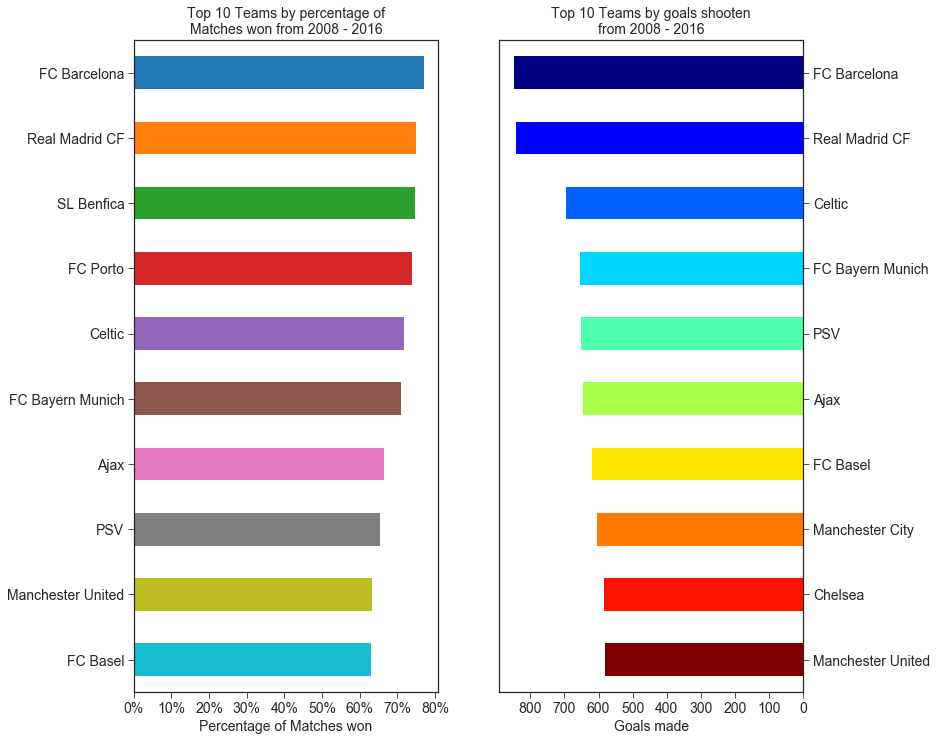

In [63]:
# create different colors
colors = plt.cm.jet(np.linspace(0, 1, 10))

# Create figure and the axes
fig, (ax_won, ax_goals) = plt.subplots(figsize=(12, 12), nrows=1, ncols=2, sharey=False)

# Plot the data of the top10 of full_teams_pct_won ---------------------------------------------------
full_teams_pct_won.nlargest(10, 'pct_won').plot.barh(x='team', y='pct_won', ax=ax_won, legend=False,
                                                     title='Top 10 Teams by percentage of\nMatches won from 2008 - 2016')

# format y axis: show Top1 at the top
# and remove the label
ax_won.invert_yaxis()
ax_won.set_ylabel('')

# format x axis: set label 
# format as Percentage
ax_won.set_xlabel('Percentage of Matches won')
ax_won.xaxis.set_major_formatter(mtick.PercentFormatter())

# plot data for top 10 of goals shooten ---------------------------------------------------------------
top10_goals_shooten.plot.barh(x='team', y='goals_shooten', legend=False, ax=ax_goals, color=colors,
                              title='Top 10 Teams by goals shooten\nfrom 2008 - 2016')

# format axis the same way as above
ax_goals.invert_yaxis()
ax_goals.set_ylabel('')
ax_goals.set_xlabel('Goals made')
# but move y labels to the right
ax_goals.yaxis.tick_right()
ax_goals.yaxis.set_label_position('right')
ax_goals.invert_xaxis()

# set fontsizes
for item in ([ax_won.xaxis.label, ax_goals.xaxis.label, ax_won.title, ax_goals.title] + ax_won.get_xticklabels() 
             + ax_won.get_yticklabels() + ax_goals.get_xticklabels() + ax_goals.get_yticklabels()):
    item.set_fontsize(14);

Most of the Top 10 Teams by Percentage of Matches won are in the list of the most shooten goals too.

Interesting fact: SL Benfica - which is on Top 3 by matches won and is one of the teams improved over the years - is not in the top 10 by goals made.
Does that mean that it is not true that more goals make for more victories?

Let's first see a plot about the relationship of percentages won with goals shooten over all teams and all seasons.

<a id="relation-between-goals-shooten-and-percentage-of-won-matches"></a>
#### Relation between Goals Shooten and Percentage of won matches

For that I can reuse **full_teams_pct_won**, which already holds the percentage of won matches for all teams over all seasons.
I will add the number of shooten goals to that frame.

In [64]:
full_teams_pct_won.head()

,matches,won,pct_won,team
team_id,,,,
1601,240,92,38.333333,Ruch Chorzów
1957,240,87,36.250000,Jagiellonia Białystok
2182,240,124,51.666667,Lech Poznań
6403,248,80,32.258065,FC Paços de Ferreira
7841,248,75,30.241935,Rio Ave FC


In [65]:
full_teams_matches.head()

,match_id,season,stage,team_id,goals_shooten,goals_conceded,won
3,4,2008/2009,1,9991,5,0,True
22,23,2008/2009,11,9991,1,1,False
41,42,2008/2009,13,9991,2,3,False
48,49,2008/2009,14,9991,4,0,True
66,67,2008/2009,16,9991,1,1,False


The name of the new frame will be to long *full_teams_pct_won_goals_shooten*, so I create a shorter name.

In [66]:
ft_pw_gs = pd.merge(full_teams_pct_won, full_teams_matches.groupby('team_id').agg({'goals_shooten':'sum'}), 
                    how='left', left_index=True, right_index=True)
ft_pw_gs.head()

,matches,won,pct_won,team,goals_shooten
team_id,,,,,
1601,240,92,38.333333,Ruch Chorzów,280
1957,240,87,36.250000,Jagiellonia Białystok,287
2182,240,124,51.666667,Lech Poznań,372
6403,248,80,32.258065,FC Paços de Ferreira,292
7841,248,75,30.241935,Rio Ave FC,248


This DataFrame compares **pct_won** and **goals_shooten** over all teams using a scatterplot.

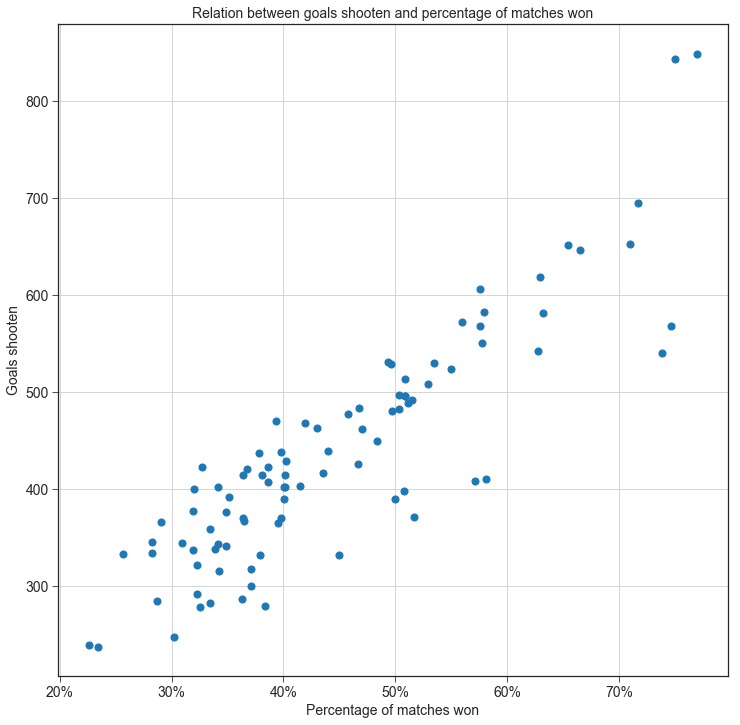

In [67]:
# create plot
ax_scat = ft_pw_gs.plot.scatter(x='pct_won', y='goals_shooten', figsize=(12,12), fontsize=14, grid=True, s=50,
                                title='Relation between goals shooten and percentage of matches won')

# customize labels
ax_scat.set_ylabel('Goals shooten')
ax_scat.set_xlabel('Percentage of matches won')

# display percentages as percentages
ax_scat.xaxis.set_major_formatter(mtick.PercentFormatter())

# set fontsizes
for item in ([ax_scat.xaxis.label, ax_scat.yaxis.label, ax_scat.title]):
    item.set_fontsize(14);

There seems to be a positive correlation between goals shooten and percentage of won matches.
I'll compare another metric: The difference of goals made and gotten.
Is should be true that shooting a lot of goals *and* prevent conceding goals makes a winner.

<a id="goal-difference"></a>
#### Goal Difference

Goal Difference is calculated by goals shooten minus goals conceded.

In [68]:
goal_diff = full_teams_matches.groupby('team_id').agg({'goals_shooten':'sum', 'goals_conceded':'sum'})
goal_diff['goal_difference'] = goal_diff['goals_shooten'] - goal_diff['goals_conceded']
goal_diff = pd.merge(goal_diff, teams, how='left', left_index=True, right_index=True)
goal_diff.head(5)

,goals_shooten,goals_conceded,goal_difference,team
team_id,,,,
1601,280,292,-12,Ruch Chorzów
1957,287,315,-28,Jagiellonia Białystok
2182,372,210,162,Lech Poznań
6403,292,349,-57,FC Paços de Ferreira
7841,248,306,-58,Rio Ave FC


This data is again plot against the Top 10 list as bar chart first.

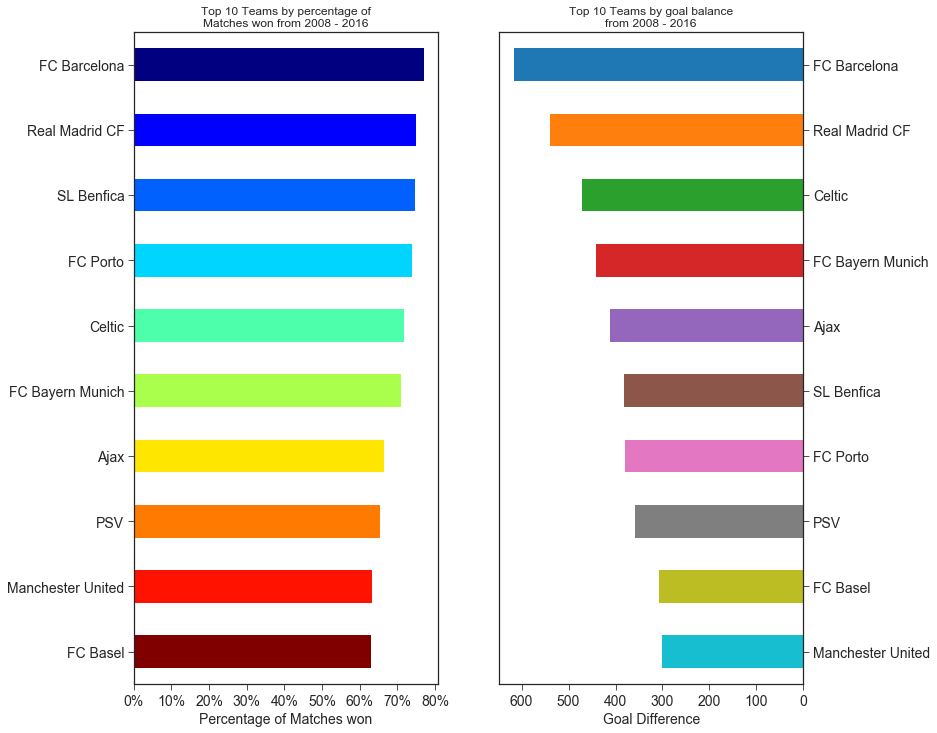

In [69]:
# Create figure and the axes
fig, (ax_won, ax_goals) = plt.subplots(figsize=(12, 12), nrows=1, ncols=2, sharey=False)

# Plot the data of the top10 of full_teams_pct_won ---------------------------------------------------
full_teams_pct_won.nlargest(10, 'pct_won').plot.barh(x='team', y='pct_won', ax=ax_won, legend=False,
                                                color=colors, title='Top 10 Teams by percentage of\nMatches won from 2008 - 2016')

# format y axis: show Top1 at the top
# and remove the label
ax_won.invert_yaxis()
ax_won.set_ylabel('')

# format x axis: set label 
# format as Percentage
ax_won.set_xlabel('Percentage of Matches won')
ax_won.xaxis.set_major_formatter(mtick.PercentFormatter())

# plot data for top 10 of goals shooten ---------------------------------------------------------------
goal_diff.nlargest(10, 'goal_difference').plot.barh(x='team', y='goal_difference', legend=False, ax=ax_goals,
                                                 title='Top 10 Teams by goal balance\nfrom 2008 - 2016')

# format axis the same way as above
ax_goals.invert_yaxis()
ax_goals.set_ylabel('')
ax_goals.set_xlabel('Goal Difference')
# but move y labels to the right
ax_goals.yaxis.tick_right()
ax_goals.yaxis.set_label_position('right')
ax_goals.invert_xaxis()

# set fontsizes
for item in ([ax_won.xaxis.label, ax_goals.xaxis.label] + ax_won.get_xticklabels() 
             + ax_won.get_yticklabels() + ax_goals.get_xticklabels() + ax_goals.get_yticklabels()):
    item.set_fontsize(14);

In addition I'll plot a scatter plot showing the relationship between the goals balance and the percentage of matches won.
I'll reuse **full_teams_pct_won** and **goal_diff** for that.

In [70]:
full_teams_pct_won.head()

,matches,won,pct_won,team
team_id,,,,
1601,240,92,38.333333,Ruch Chorzów
1957,240,87,36.250000,Jagiellonia Białystok
2182,240,124,51.666667,Lech Poznań
6403,248,80,32.258065,FC Paços de Ferreira
7841,248,75,30.241935,Rio Ave FC


In [71]:
goal_diff.head()

,goals_shooten,goals_conceded,goal_difference,team
team_id,,,,
1601,280,292,-12,Ruch Chorzów
1957,287,315,-28,Jagiellonia Białystok
2182,372,210,162,Lech Poznań
6403,292,349,-57,FC Paços de Ferreira
7841,248,306,-58,Rio Ave FC


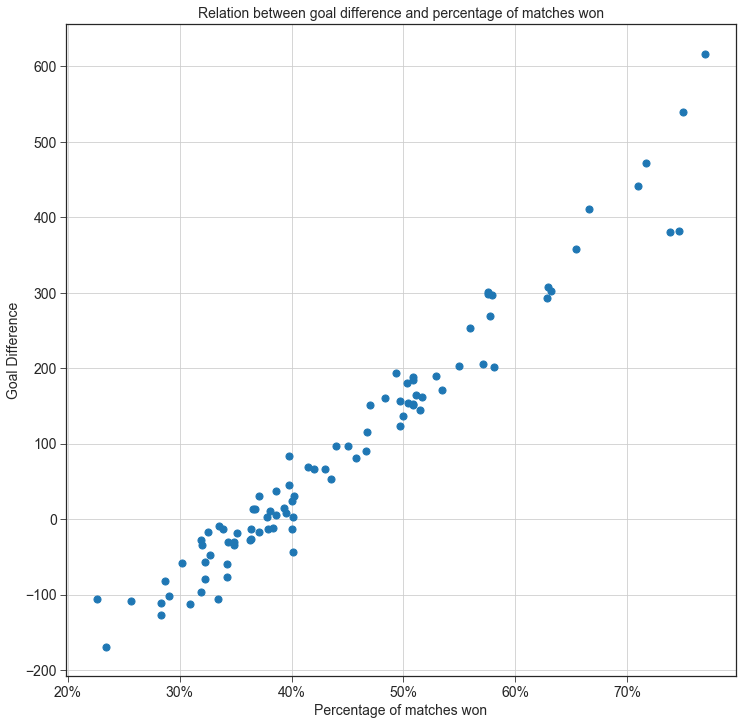

In [72]:
# create the axis
ax_diff = pd.merge(full_teams_pct_won, goal_diff).plot.scatter(x='pct_won', y='goal_difference', figsize=(12,12),
                                                               fontsize=14, grid=True, s=50, 
                                                               title='Relation between goal difference and percentage of matches won')

# customize labels
ax_diff.set_ylabel('Goal Difference')
ax_diff.set_xlabel('Percentage of matches won')

# display percentages as percentages
ax_diff.xaxis.set_major_formatter(mtick.PercentFormatter())

# set fontsizes
for item in ([ax_diff.xaxis.label, ax_diff.yaxis.label, ax_diff.title]):
    item.set_fontsize(14);

That seems to be more clear: Both lists contain the same teams and there is a positive correlation between the goal difference and the percentage of matches won.
Shooting lots of goals and not conceding goals seems to be a success factor.
Perhaps this is seen even more obvious by comparing this goal difference directly by plotting goals shooten and conceded in one plot for every team.

<a id="goal-breakdown"></a>
#### Goal Breakdown

For that analysis I can reuse the Dataframe holding all matches of the top 10 teams.

In [73]:
top10_teams_matches.head()

,match_id,season,stage,team_id,goals_shooten,goals_conceded,won,team
1728,1729,2008/2009,1,10260,1,1,False,Manchester United
1738,1739,2008/2009,10,10260,2,0,True,Manchester United
1748,1749,2008/2009,11,10260,4,3,True,Manchester United
1768,1769,2008/2009,13,10260,5,0,True,Manchester United
1798,1799,2008/2009,16,10260,1,0,True,Manchester United


The Dataframe is grouped again by team and seasion.
But this time I aggregate goals shooten and goals conceded using **sum** and unstack at level 1.

In [74]:
aggregations = {'goals_shooten':'sum', 'goals_conceded':'sum'}
top10_goal_breakdown = top10_teams_matches.groupby(['team','season']).agg(aggregations).unstack(level=1)
top10_goal_breakdown

goals_shooten                                          \
season                2008/2009 2009/2010 2010/2011 2011/2012 2012/2013   
team                                                                      
Ajax                         74       106        72        93        83   
Celtic                       80        75        85        84        92   
FC Barcelona                105        98        95       114       115   
FC Basel                     72        90        76        78        61   
FC Bayern Munich             71        72        81        77        98   
FC Porto                     61        70        73        69        70   
Manchester United            68        86        78        89        86   
PSV                          71        72        79        87       103   
Real Madrid CF               83       102       102       121       103   
SL Benfica                   54        78        61        66        77   

                                                goals_conceded            \
season            2013/2014 2014/2015 2015/2016      2008/2009 2009/2010   
team                                                                       
Ajax                     69        69        81             41        20   
Celtic                  102        84        93             33        39   
FC Barcelona            100       110       112             35        24   
FC Basel                 70        84        88             44        46   
FC Bayern Munich         94        80        80             42        31   
FC Porto                 57        74        67             18        26   
Manchester United        64        62        49             24        28   
PSV                      60        92        88             33        29   
Real Madrid CF          104       118       110             52        35   
SL Benfica               58        86        88             32        20   

                                                                               
season            2010/2011 2011/2012 2012/2013 2013/2014 2014/2015 2015/2016  
team                                                                           
Ajax                     30        36        31        28        29        21  
Celtic                   22        21        35        25        17        31  
FC Barcelona             21        29        40        33        21        29  
FC Basel                 44        33        31        34        41        38  
FC Bayern Munich         40        22        18        23        18        17  
FC Porto                 16        19        14        25        13        30  
Manchester United        37        33        43        43        37        35  
PSV                      34        47        43        45        31        32  
Real Madrid CF           33        32        42        38        38        34  
SL Benfica               31        27        20        18        16        22

This frame will be plotted by one plot per team.

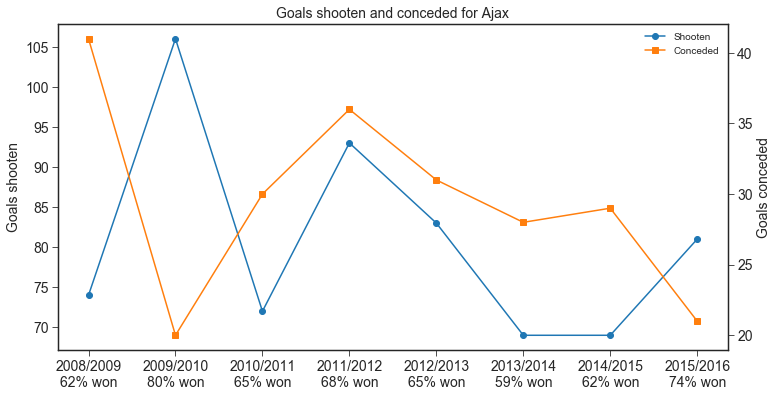

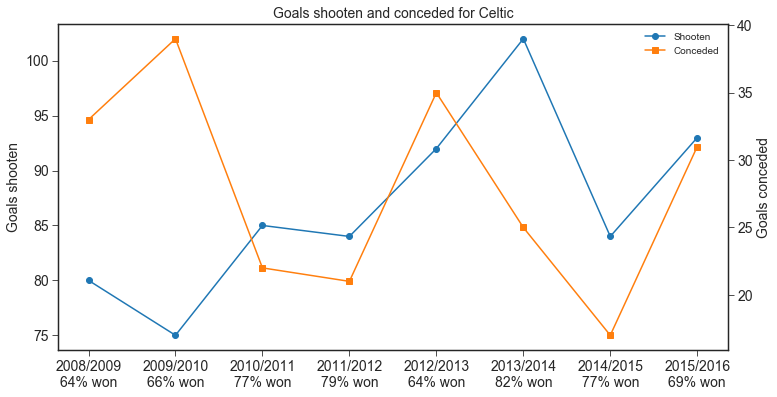

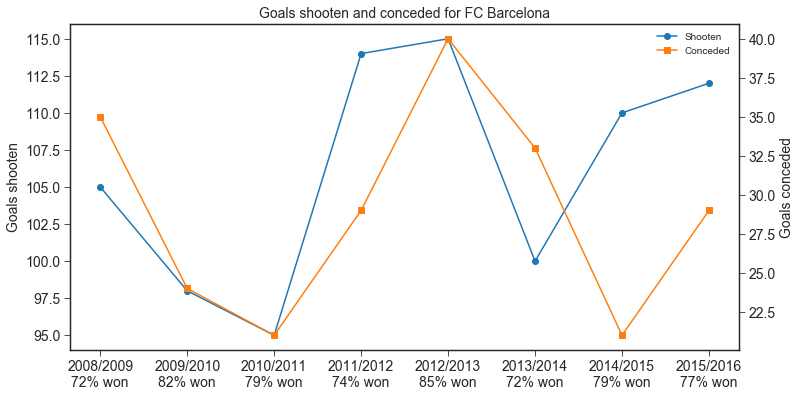

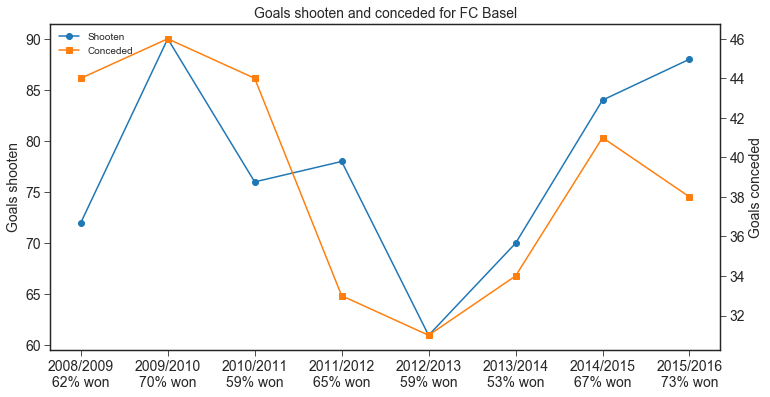

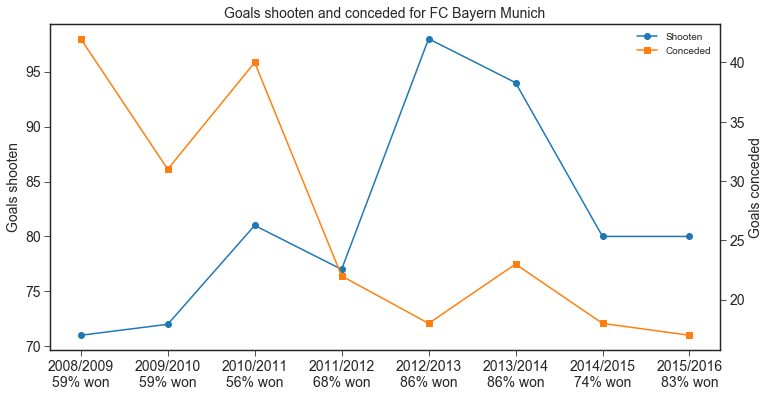

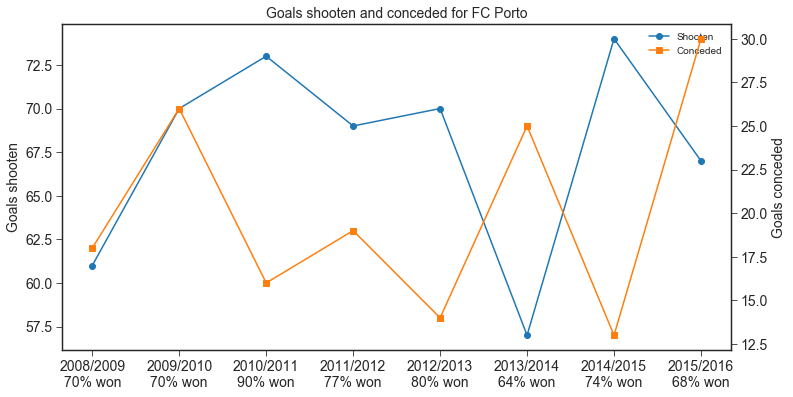

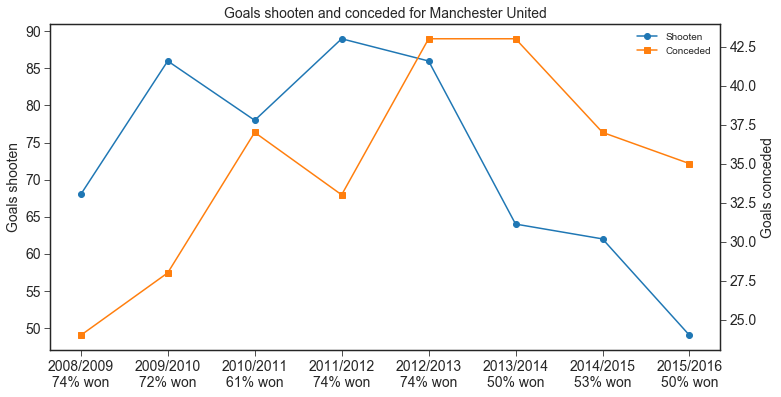

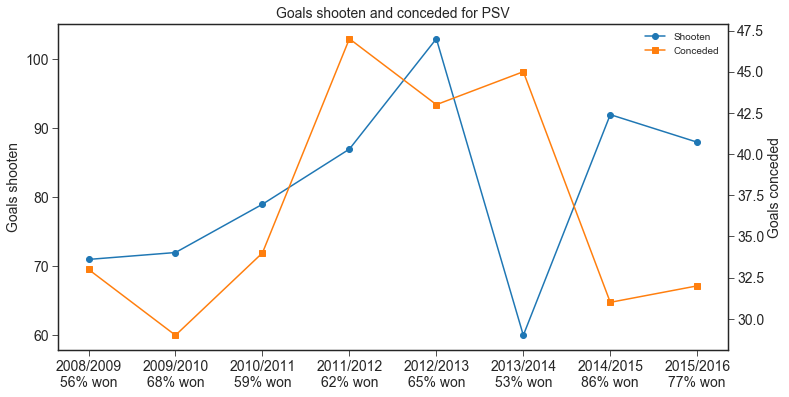

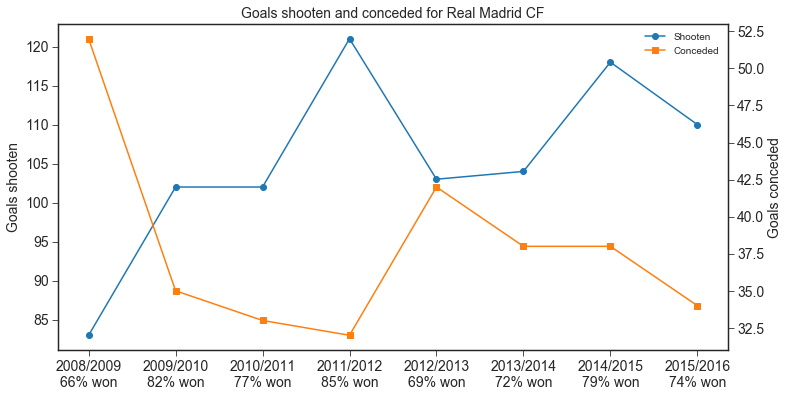

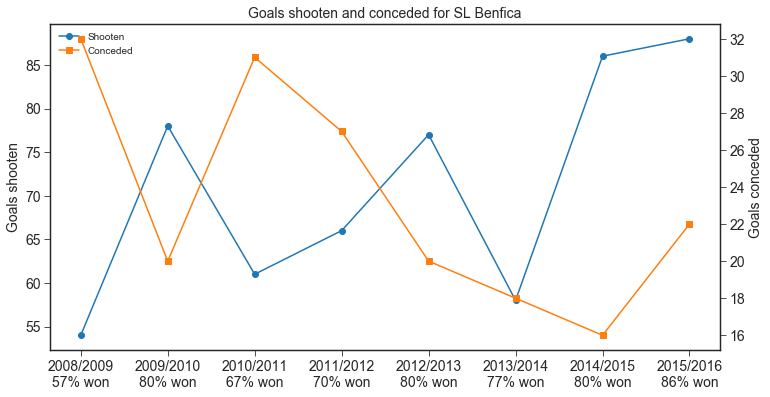

In [75]:
for team in top10_goal_breakdown.index.values:
    # create figure and axis
    fig, ax = plt.subplots()

    # plot goals shooten per season
    team_ps = top10_goal_breakdown.loc[team]
    team_ps.goals_shooten.plot(ax=ax, figsize=(12,6), marker='o', rot=45, grid=True, legend=True, 
                               xticks=range(len(team_ps.goals_shooten)), label='Shooten',
                               title='Goals shooten and conceded for {}'.format(team))

    # plot goals conceded per season
    team_ps.goals_conceded.plot(ax=ax, secondary_y=True, marker='s', legend=True, mark_right=False,
                                label='Conceded');

    # display y-labels
    ax.set_ylabel('Goals shooten')
    ax.right_ax.set_ylabel('Goals conceded')

    # and hide x-label
    ax.set_xlabel('')

    # set legend
    lines = ax.get_lines() + ax.right_ax.get_lines()
    ax.legend(lines, [l.get_label() for l in lines])
    
    # modify xticklabels
    labels = []
    for item in ax.get_xticklabels():
        season_ix=item.get_text()
        pct_won=math.ceil(top10_won_pct_per_season.loc[season_ix].loc[team])
        labels.append('{}\n{}% won'.format(season_ix, pct_won))
    ax.set_xticklabels(labels, fontsize=14)

    # set fontsizes
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.right_ax.yaxis.label] 
                 + ax.get_xticklabels() + ax.get_yticklabels() + ax.right_ax.get_yticklabels()):
        item.set_fontsize(14);

The relationship between these two variables can be seen best for **SL Benefica** and **FC Bayern Munich**.
Both teams consistently shoot more goals and conced less.
They seem to have better forwards and defenders from season to season.

<a id='conclusions'></a>
## Conclusions

During this project the Top 10 teams over 8 seasons of soccer matches are identified. 
For that investigation only 92 out of 296 teams were analyzed because they played all 8 seasons.
Due to missing values in other tables only data from the **matches** and **team** tables was used.
Matches that were hold by two teams that played less than these 8 seasons were not considered.
Every match at which a team participated that played these 8 seasons was counted.
Hence only 19340 of 25979 matches were used during the analysis.

During the data cleaning 84 matches were deleted due to duplicates in the **team** table.
An alternative of dropping these matches would be to search for the match information in the internet to update the base table with the correct values.

The top 10 teams are 

1. FC Barcelona
2. Real Madrid CF
3. SL Benfica
4. FC Porto
5. Celtic
6. FC Bayern Munich
7. Ajax
8. PSV
9. Manchester United
10. FC Basel

To get this list only two variables were used: The goals shooten and the goals conceded for every match.
From these values the match outcome was derived (won, loss or draw).
Using this derived column the sum of matches was calculated as well as the sum of won matches.
No other statistic than that was used to find this list.

The investigation then continued to show the progress these 10 teams made during these 8 seasons.
It can be seen that all teams had ups and downs regarding the percentage of won matches over these years and no team steadily improved from year to year.
Furthermore from all Teams **Manchester United** was the only one steadily decrreasing its performance.
Lastly three teams improved more than the others:

- SL Benfica
- FC Bayern Munich
- PSV increased

After this one statistic was used to investigate what contributes to the performance of these teams: The number of goals shooten.
The theory is that every team shooting a lot of goals must win more matches. 
To proof that the number of goals shooten for every team was calculated and plotted two times:

1. A top 10 list of goals shooten besides the top 10 list of the most sucessfull teams.
2. The relation of the percentage of won matches and goals shooten.

The result does not clearly show the relation but a trend that more goals lead to more victories.
But one can see that **SL Benfica** is not in the top 10 list of goals shooten.

Thus the exploration continued by using the goal difference as one factor for winning matches.
The result of this exploration is more compelling: All top 10 teams by percentage of won matches are as well in the top 10 list by goal difference. 
In addition the positive relationship between these two variables can be seen best for SL Benefica and FC Bayern Munich. 
Both teams consistently shoot more goals and conced less by winning more matches in the same season.

Hence it seems that shooting a lot of goals and conceded less is one factor of winning teams.

<a id='outlook'></a>
## Outlook

As this project used only the statistic of shooten and conceded goals there will be in fact a lot more factors contributing to winning teams. 

For example the FIFA video game series rolls up team statistics that are store in this case in the table **Team_Attributes**.
This table might be used to answer questions like: 

- Are more defensive teams sucessfull?
- What is the best balance between defence and forwards to be sucessfull?
- What type of build up play leads to more victories?
- What defence aggression is needed to prevent conceding goals?

In addition the Player_Attributes table might be used to ask:

- Does a team having more players with high overall rating wins more often?
- Which player should not shoot penalties? Which one should?
- What is the best age for having the highest overall rating?

From the matches table other fields can be used to ask:

- When do the top 10 teams do shoot the most goals?
- Are players of the best teams fouled more often?
- Do the best teams shoot more goals using corners?


<a id='appendix-a-entity-relationship-model-of-soccer-database'></a>
## Appendix A: Entity-Relationship Model of Soccer Database

![ER Model of Soccer Database](schema-layout.jpg)

<a id='appendix-b-table-fields'></a>
## Appendix B: Table Fields

<a id='country'></a>
### Country

We need to reset the maximum rows displayed in a output cell first.

In [76]:
pd.read_sql_query("PRAGMA table_info('Country');",  db_connection)

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,0,None,1
1,1,name,TEXT,0,None,0


| Field Name | Description     |
| ---------- | --------------- |
| id         | Id of Country   |
| name       | Name of Country |

<a id='league'></a>
### League

In [77]:
pd.read_sql_query("PRAGMA table_info('League');",  db_connection)

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,0,None,1
1,1,country_id,INTEGER,0,None,0
2,2,name,TEXT,0,None,0


| Field Name | Description             |
| ---------- | ----------------------- |
| id         | Id of League            |
| country_id | Id of Country of League |
| name       | Name of League          |

<a id='match'></a>
### Match

In [78]:
pd.read_sql_query("PRAGMA table_info('Match');",  db_connection)

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,0,None,1
1,1,country_id,INTEGER,0,None,0
2,2,league_id,INTEGER,0,None,0
3,3,season,TEXT,0,None,0
4,4,stage,INTEGER,0,None,0
5,5,date,TEXT,0,None,0
6,6,match_api_id,INTEGER,0,None,0
7,7,home_team_api_id,INTEGER,0,None,0
8,8,away_team_api_id,INTEGER,0,None,0
9,9,home_team_goal,INTEGER,0,None,0


| Field Name | Description |
| ---------- | ----------- |
| id | Primary Key |
| country_id | Id of Country |
| league_id | Id of League |
| season | Season of the Match |
| stage | Matchday in the season |
| date | Date of Match |
| match_api_id | API ID of Match |
| home_team_api_id | API ID of Home Team |
| away_team_api_id | API ID of Away Team |
| home_team_goal | Final result - Goals of Home Team |
| away_team_goal | Final result - Goald of Away Team |
| home_player_X1 to home_player_X11 | Position X of Players 1 to 11 of Home Team  |
| away_player_X1 to away_player_X11 | Position X of Players 1 to 11 of Away Team |
| home_player_Y1 to home_player_Y11 | Position Y of Players 1 to 11 of Home Team |
| away_player_Y1 to away_player_Y11 | Position Y of Players 1 to 11 of Away Team |
| home_player_1 to home_player_11 | IDs (in Player) of Players 1 to 11 of Home Team |
| away_player_1 to away_player_11 | IDs (in Player) of Players 1 to 11 of Away Team |
| goal | XML String holding all goals made during the match including Team, Player, Minute etc. |
| shoton | XML String holding all shoots on goal including Team, Player, Type of shoot, Minute etc. |
| shotoff | XML String holding all shoots off target including Team, Player, Type of shoot, Minute etc. |
| foulcommit | XML String holding all fouls including Team, Players, elapsed Minute etc. |
| card | XML String holding all cards given including Team, Player, Type of Card, Minute etc. |
| "cross" | XML String holding all crosses including Team, Player, Minute etc. (sometimes corners are stored here as well) |
| corner | XML String holding all corners including Team, Player, elapsed Minute etc. |
| possession | XML String holding posession |
| B365H | Bet365 home win odds |
| B365D | Bet365 draw odds |
| B365A | Bet365 away win odds |
| BWH | Bet&Win home win odds |
| BWD | Bet&Win draw odds |
| BWA | Bet&Win away win odds |
| IWH | Interwetten home win odds |
| IWD | Interwetten draw odds |
| IWA | Interwetten away win odds |
| LBH | Ladbrokes home win odds |
| LBD | Ladbrokes draw odds |
| LBA | Ladbrokes away win odds |
| PSH | Pinnacle home win odds |
| PSD | Pinnacle draw odds |
| PSA | Pinnacle away win odds |
| WHH | William Hill home win odds |
| WHD | William Hill draw odds |
| WHA | William Hill away win odds |
| SJH | Stan James home win odds |
| SJD | Stan James draw odds |
| SJA | Stan James away win odds |
| VCH | VC Bet home win odds |
| VCD | VC Bet draw odds |
| VCA | VC Bet away win odds |
| GBH | Gamebookers home win odds |
| GBD | Gamebookers draw odds |
| GBA | Gamebookers away win odds |
| BSH | Blue Square home win odds |
| BSD | Blue Square draw odds |
| BSA | Blue Square away win odds |


<a id='player'></a>
### Player

In [79]:
pd.read_sql_query("PRAGMA table_info('Player');",  db_connection)

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,0,None,1
1,1,player_api_id,INTEGER,0,None,0
2,2,player_name,TEXT,0,None,0
3,3,player_fifa_api_id,INTEGER,0,None,0
4,4,birthday,TEXT,0,None,0
5,5,height,INTEGER,0,None,0
6,6,weight,INTEGER,0,None,0


| Field Name | Description |
| ---------- | ----------- |
| id | Id of Player |
| player_api_id | player_api_id |
| player_name | Name of Player |
| player_fifa_api_id | API Id in FIFA |
| birthday | Day of Birth |
| height | Height |
| weight | Weight |

<a id='player_attributes'></a>
### Player_Attributes

In [80]:
pd.read_sql_query("PRAGMA table_info('Player_Attributes');",  db_connection)

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,0,None,1
1,1,player_fifa_api_id,INTEGER,0,None,0
2,2,player_api_id,INTEGER,0,None,0
3,3,date,TEXT,0,None,0
4,4,overall_rating,INTEGER,0,None,0
5,5,potential,INTEGER,0,None,0
6,6,preferred_foot,TEXT,0,None,0
7,7,attacking_work_rate,TEXT,0,None,0
8,8,defensive_work_rate,TEXT,0,None,0
9,9,crossing,INTEGER,0,None,0


| Field Name | Description |
| ---------- | ----------- |
| id | Id of Player |
| player_fifa_api_id | API Id in FIFA |
| player_api_id | player_api_id |
| date | Date of Rating |
| overall_rating | average of the key Player Attributes rates of a player within their Potential rate calculated based on their position and international reputation. The OVR rating of a player determines their general performance quality and their value in FIFA |
| potential | the rating he could possible grow to |
| preferred_foot | Preferred Foot |
| attacking_work_rate | How a player participates in attacks. Rated as low, medium and high. |
| defensive_work_rate | How a player participates in defensive plays. Rated as low, medium and high. |
| crossing | The accuracy and the quality of a player’s crosses |
| finishing | The ability of a player to score |
| heading_accuracy | A player’s accuracy when using the head to pass, shoot or clear the ball |
| short_passing | A player’s accuracy for the short passes |
| volleys | A player’s ability for performing volleys |
| dribbling | A player’s ability to carry the ball and past an opponent |
| curve | A player’s ability to curve the ball when passing and shooting |
| free_kick_accuracy | A player’s accuracy for taking the Free Kicks |
| long_passing | A player’s accuracy for the long passes |
| ball_control | The ability of a player to control the ball |
| acceleration | The increment of a player’s running speed |
| sprint_speed | Defines the speed rate of a player’s sprinting |
| agility | Determines how fast and graceful a player is able to control the ball |
| reactions | The acting speed of a player in response to the situations happening around them |
| balance | The even distribution of enabling a player to remain upright and steady when running |
| shot_power | The strength of a player’s shootings |
| jumping | A player’s ability and quality for jumping from the surface for headers |
| stamina | A player’s ability to sustain prolonged physical or mental effort |
| strength | The quality or state of being physically strong |
| long_shots | A player’s accuracy for the shots taking from long distances |
| aggression | The aggression level of a player |
| interceptions | A player’s capability to intercept the ball |
| positioning | Defines how well a player is able to perform the positioning on the field |
| vision | A player’s mental awareness about his teammates’ positioning, for passing the ball to them |
| penalties | A player’s accuracy for taking penalty shots |
| marking | A player’s capability to mark opposition player(s) |
| standing_tackle | The ability of performing standing tackle |
| sliding_tackle | The ability of performing sliding tackle |
| gk_diving | a player's ability to dive as a goalkeeper |
| gk_handling | a player's ability to handle the ball and hold onto it using their hands as a goalkeeper |
| gk_kicking | a player's ability to kick the ball as a goalkeeper |
| gk_positioning | Positioning (POS) is a Player Attribute in FIFA that determines that how well a player is able to perform the positioning on the field as a player or on the goal line as a goalkeeper. |
| gk_reflexes | Reflexes (REF) is a Player Attribute in FIFA that determines a player's ability and speed to react (reflex) for catching/saving the ball as a goalkeeper. |

<a id='team'></a>
### Team

In [81]:
pd.read_sql_query("PRAGMA table_info('Team');",  db_connection)

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,0,None,1
1,1,team_api_id,INTEGER,0,None,0
2,2,team_fifa_api_id,INTEGER,0,None,0
3,3,team_long_name,TEXT,0,None,0
4,4,team_short_name,TEXT,0,None,0


| Field Name | Description |
| ---------- | ----------- |
| id | Primary Key |
| team_api_id | API ID in football-data.org |
| team_fifa_api_id | ID in FIFA API |
| team_long_name | Name of Team |
| team_short_name | Abbreviation of Team Name (3 Chars) |

<a id='team_attributes'></a>
### Team_Attributes

In [82]:
pd.read_sql_query("PRAGMA table_info('Team_Attributes');",  db_connection)

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,0,None,1
1,1,team_fifa_api_id,INTEGER,0,None,0
2,2,team_api_id,INTEGER,0,None,0
3,3,date,TEXT,0,None,0
4,4,buildUpPlaySpeed,INTEGER,0,None,0
5,5,buildUpPlaySpeedClass,TEXT,0,None,0
6,6,buildUpPlayDribbling,INTEGER,0,None,0
7,7,buildUpPlayDribblingClass,TEXT,0,None,0
8,8,buildUpPlayPassing,INTEGER,0,None,0
9,9,buildUpPlayPassingClass,TEXT,0,None,0


| Field Name | Description |
| ---------- | ----------- |
| id | Primary Key |
| team_fifa_api_id | ID in FIFA API |
| team_api_id | API ID in api.football-data.org |
| date | Date of Rating (seems to be yearly) |
| buildUpPlaySpeed | The speed in which attacks are put together |
| buildUpPlaySpeedClass | The class of Play Speed (Slow, Balanced, Fast) |
| buildUpPlayDribbling | *unknown* |
| buildUpPlayDribblingClass | Classes: Little, Normal, Lots |
| buildUpPlayPassing | Affects passing distance & support from teammates |
| buildUpPlayPassingClass | The class of Play Passing (Short, Mixed, Long) |
| buildUpPlayPositioningClass | A team’s freedom of movement in the 1st two thirds of the pitch (Organised, Free Form) |
| chanceCreationPassing | Amount of risk in pass decision and run support |
| chanceCreationPassingClass | Class of this: Safe, Normal, Risky |
| chanceCreationCrossing | The tendency / frequency of crosses into the box |
| chanceCreationCrossingClass | Class of this: Little, Normal, Lots |
| chanceCreationShooting | The tendency / frequency of shots taken |
| chanceCreationShootingClass | Classes: Little, Normal, Lots |
| chanceCreationPositioningClass | A team’s freedom of movement in the final third of the pitch (Organised, Free Form) |
| defencePressure | Affects how high up the pitch the team will start pressuring |
| defencePressureClass | Classes: Deep, Medium, High |
| defenceAggression | Affect the team’s approach to tackling the ball possessor |
| defenceAggressionClass | Classes: Contain, Press, Double |
| defenceTeamWidth | Affects how much the team will shift to the ball side |
| defenceTeamWidthClass | Classes of this: Narrow, Normal, Wide |
| defenceDefenderLineClass | Affects the shape and strategy of the defence: Cover, Offside Trap |

<a id='appendix-c-references'></a>
## Appendix C: References

Alongside the pages used above these sources are used to build up this report:

- [Summarising, Aggregating, and Grouping data in Python Pandas](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)
- Parts of the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/)
- [Apply Operations To Groups In Pandas](https://chrisalbon.com/python/data_wrangling/pandas_apply_operations_to_groups/)
- Documentation of Pandas
- Documentation of matplotlib
- Stack Overflow (a lot!)

In [83]:
# close connection to the database as last step as we needed it to create Appendix B
db_connection.close()